In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Importing our data
data = pd.read_excel('table_8_offenses_known_to_law_enforcement_washington_by_city_2013.xls', 
                     encoding='latin1', skiprows=list(range(4)))
# Condense and clean our dataset
data = data.rename(index = str, columns={'Murder and\nnonnegligent\nmanslaughter': 'Murder', 'Property\ncrime': "Property_crime"})
data = data[['Population', 'Murder', 'Robbery', 'Property_crime', 'Burglary']]
data = data.dropna()

# Create the new rows for our regression model
data['Pop_squared'] = data['Population']**2

# Preview the data
data.head()

,Population,Murder,Robbery,Property_crime,Burglary,Pop_squared
0,16408.000,0.000,13.000,944.000,208.000,269222464.000
1,6441.000,0.000,6.000,333.000,72.000,41486481.000
2,3123.000,0.000,0.000,73.000,22.000,9753129.000
3,15980.000,0.000,3.000,559.000,127.000,255360400.000
4,18425.000,0.000,11.000,1124.000,198.000,339480625.000


In [3]:
# View the column statistics
data.describe()

,Population,Murder,Robbery,Property_crime,Burglary,Pop_squared
count,182.000,182.000,182.000,182.000,182.000,182.000
mean,23097.291,0.549,27.577,1057.478,208.390,3721156113.808
std,56615.216,2.021,132.211,3321.380,679.726,30982972046.175
min,278.000,0.000,0.000,0.000,0.000,77284.000
25%,2767.500,0.000,0.000,53.000,11.000,7659273.000
50%,7359.000,0.000,2.000,249.000,48.500,54155170.000
75%,20155.750,0.000,9.000,678.500,135.000,406305153.250
max,642814.000,19.000,1601.000,35883.000,7384.000,413209838596.000


In [4]:
# Construct our linear regression model with our X variables 
# and predict Y
regr = linear_model.LinearRegression()
X = data[['Population', 'Murder', 'Robbery', 'Pop_squared']]
Y = data['Property_crime'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.37246256e-02  2.62429363e+01  2.51147725e+01 -4.84154524e-08]]

Intercept: 
 [-17.34245159]

R-squared:
0.9829234289645801


In [5]:
# Review the correlation matrix
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Murder,Robbery,Pop_squared
Population,1.000,0.876,0.952,0.895
Murder,0.876,1.000,0.891,0.770
Robbery,0.952,0.891,1.000,0.948
Pop_squared,0.895,0.770,0.948,1.000


# PCA

In [6]:
pca = PCA(n_components=1)
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1'])
principalDf.head()

,principal component 1
0,-0.304
1,-0.424
2,-0.478
3,-0.347
4,-0.292


In [7]:
# How much of our variance do we retain after limiting our data to 1 component?
pca.explained_variance_ratio_

array([0.91725437])

In [8]:
# Create a new linear regression model with our 1 variable
X = principalDf
Y = data['Property_crime'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1680.62298148]]

Intercept: 
 [1057.47802198]

R-squared:
0.9445956564588894


In [9]:
# Creating our residual graph based on predicted and actual values
predicted = regr.predict(X).ravel()
target = data['Property_crime']
residual = target - predicted

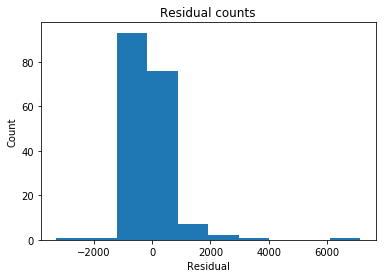

In [12]:
# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

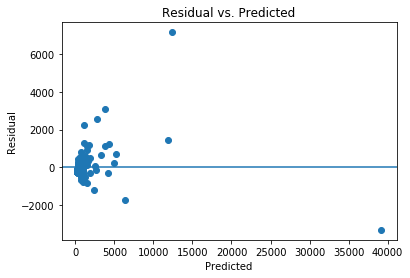

In [10]:
# Create our residual graph
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Cross Validation

In [11]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

# Create our model distribution
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Create cross validation with 5 groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.0
Testing on Sample: 0.04945054945054945
